In [1]:
import pandas as pd
import torch
import clip
import requests
from PIL import Image
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import Blip2Processor, Blip2ForConditionalGeneration

/work/pi_rachel_melamed_uml_edu/anugrah_vaishnav_student_uml_edu-conda/envs/anuenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LLaVa

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model_processor(model_name):
    if model_name == "llava":
        model_pref = "llava-hf/llava-v1.6-mistral-7b-hf"
        processor = LlavaNextProcessor.from_pretrained(model_pref)

        model = LlavaNextForConditionalGeneration.from_pretrained(
            model_pref, torch_dtype=torch.float16, low_cpu_mem_usage=True
        )
        model.to(device)
    elif model_name == "clip":
        model, processor = clip.load("ViT-B/32", device=device)

    return model, processor

llava_model, llava_processor = get_model_processor("llava")
# clip_model, clip_processor = get_model_processor("clip")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]


In [4]:
# url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
url = "https://cs.stanford.edu/people/rak248/VG_100K_2/456.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [7]:
import re

def generate_caption_from_image(model, processor, image, max_new_tokens=50):
    
    # Generate prompt
    wcot_prompt = "[INST] <image>\nGenerate a caption for this image[/INST]"
    cot_prompt = "[INST] <image>\nGenerate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it[/INST]"

    # Process prompt
    wcot_inputs = processor(wcot_prompt, image, return_tensors="pt").to(device)
    cot_inputs = processor(cot_prompt, image, return_tensors="pt").to(device)

    # autoregressively complete prompt
    wcot_output = model.generate(**wcot_inputs, max_new_tokens=max_new_tokens)
    cot_output = model.generate(**cot_inputs, max_new_tokens=max_new_tokens)

    # Decode output
    wcot_final_output = processor.decode(wcot_output[0], skip_special_tokens=True)
    cot_final_output = processor.decode(cot_output[0], skip_special_tokens=True)
    
    print(wcot_final_output, type(wcot_final_output))
    print(cot_final_output, type(cot_final_output), '\n')
    
    wcot_final_output = wcot_final_output.split("[/INST]")[-1].strip()
    cot_final_output = cot_final_output.split("[/INST]")[-1].strip()
    
    print(wcot_final_output, type(wcot_final_output))
    print(cot_final_output, type(cot_final_output), '\n')
    
    if '"' in wcot_final_output:
        if wcot_final_output[-1] != '"':
            wcot_final_output = wcot_final_output + '"'
            
    if '"' in cot_final_output:
        if cot_final_output[-1] != '"':
            cot_final_output = cot_final_output + '"'
    
    wcot_final_output = re.findall(r'"(.*?)"', wcot_final_output) if '"' in wcot_final_output else wcot_final_output
    cot_final_output = re.findall(r'"(.*?)"', cot_final_output) if '"' in cot_final_output else cot_final_output
    
    print(wcot_final_output, type(wcot_final_output))
    print(cot_final_output, type(cot_final_output), '\n')
    
    wcot_final_output = wcot_final_output[0] if wcot_final_output else ""
    cot_final_output = cot_final_output[0] if cot_final_output else ""
    
    print(wcot_final_output)
    print(cot_final_output)
    
    # Process the output
    # wcot_final_output = wcot_final_output.split("[/INST]")[-1].strip().split('"')[1] # remove prompt
    # cot_final_output = cot_final_output.split("[/INST]")[-1].strip().split('"')[1] # remove prompt

    return wcot_final_output, cot_final_output


In [8]:
wcot_caption, cot_caption = generate_caption_from_image(llava_model, llava_processor, image, max_new_tokens=50)
# print(f"WCOT Caption: {wcot_caption}")
# print(f"COT Caption: {cot_caption}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
Generate a caption for this image[/INST] "A quiet city street under a clear blue sky, with a mix of modern and traditional architecture."  <class 'str'>
[INST]  
Generate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it[/INST] "A bustling city street with a mix of modern and traditional architecture, a clear blue sky, and a few trees and cars adding to the urban landscape."  <class 'str'> 

"A quiet city street under a clear blue sky, with a mix of modern and traditional architecture." <class 'str'>
"A bustling city street with a mix of modern and traditional architecture, a clear blue sky, and a few trees and cars adding to the urban landscape." <class 'str'> 

['A quiet city street under a clear blue sky, with a mix of modern and traditional architecture.'] <class 'list'>
['A bustling city street with a mix of modern and traditional architecture, a clear blue sky, and a few trees and cars adding 

In [13]:
def process_caption(caption):
    # first_split = caption.split("[/INST]")[-1].strip() # remove prompt
    second_split = caption.split('. ') # split into sentences

    # remove last sentence if it doesn't end with a period
    if not second_split[-1].endswith('.'):
        second_split.pop()
        
    final_string = '. '.join(second_split) # join sentences
    if not final_string.endswith('.'):
        final_string += '.'
    return final_string

In [11]:
process_wcot_caption = process_caption(wcot_caption)
process_cot_caption = process_caption(cot_caption)
print(f"Processed WCOT Caption: {process_wcot_caption}")
print(f"Processed COT Caption: {process_cot_caption}")

Processed WCOT Caption: A quiet city street under a clear blue sky, with a mix of modern and traditional architecture.
Processed COT Caption: A bustling city street with a mix of modern and traditional architecture, a clear blue sky, and a few trees and cars adding to the urban landscape.


In [38]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [39]:
def get_predicted_labels_clip(model, preprocess, image, captions):
    img = (
        preprocess(image)
        .unsqueeze(0)
        .to(device)
    )
    text = clip.tokenize(captions).to(device)

    with torch.no_grad():
        logits_per_image, _ = model(img, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    final_pred = probs[0].argmax()
    # print("Label probs:", final_pred)

    # if final_pred == 0:
    #     print("WCOT", wcot_caption)
    # else:
    #     print("COT", cot_caption)

    if final_pred == 0:
        return "A"
    else:
        return "B"

In [40]:
valid_outcomes = [process_wcot_caption, process_cot_caption]
clip_pred = get_predicted_labels_clip(clip_model, clip_processor, image, valid_outcomes)

In [41]:
def get_predicted_labels_llm(model, processor, image, options, max_new_tokens=50):
    
    # Generate prompt
    prompt = f"[INST] <image>\nWhich caption is a better choice for the given image: (A) {options[0]} or (B) {options[1]}? Give only the option letter to me.[/INST]"

    # Process prompt
    inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=max_new_tokens)

    # Decode output
    final_output = processor.decode(output[0], skip_special_tokens=True)
    
    final_output = final_output.split("[/INST]")[-1].strip() # remove prompt
    
    return final_output
    # if final_output == 'A':
    #     # print(f"Selected caption: WCOT: {options[0]}")
    #     return 0
    # else:
    #     # print(f"Selected caption: COT: {options[1]}")
    #     return 1

In [42]:
llm_pred = get_predicted_labels_llm(llava_model, llava_processor, image, valid_outcomes)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [7]:
import random
def get_human_pref_caption(image, captions):
    display(image)
    print('There are 2 captions. Which one do you prefer from the ones?')
    
    # Shuffle the captions to avoid bias
    random.shuffle(captions)
    
    print(f'Caption (A): {captions[0]}')
    print(f'Caption (B): {captions[1]}')
    
    possible_inputs = ['A', 'B']
    for attempts in range(3):
        human_input = input(f"Attempt: {attempts+1}. Enter either option 'A' or 'B'")
        if human_input in possible_inputs:
            return human_input
        else:
            print('Invalid input. Please try again!')
    
    # if human_input == 1:
    #     return 'A'
    # else:
    #     return 'B'

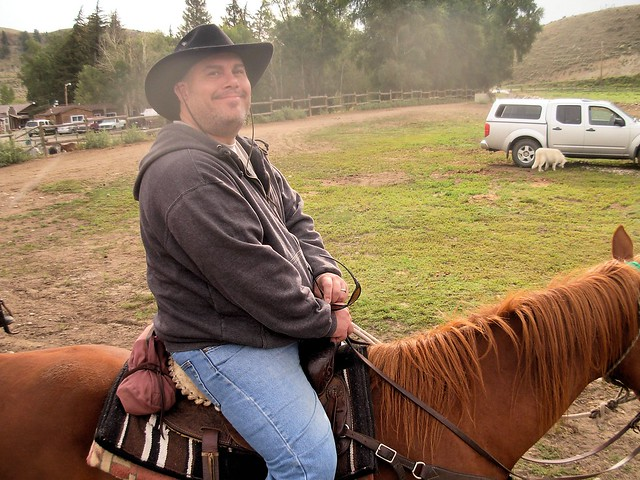

There are 2 captions. Which one do you prefer from the ones?
Caption (A): A day of adventure in the great outdoors.
Caption (B): A man enjoying a horseback ride in a rural setting, with a backdrop of a pickup truck and a fence, under a clear sky.


In [45]:
human_pred = get_human_pref_caption(image, valid_outcomes)

In [46]:
results_df = pd.DataFrame(columns=['image_url', 'caption_A', 'caption_B', 'human_output', 'llm_output', 'clip_output'])

results_df.loc[-1] = [url, process_wcot_caption, process_cot_caption, human_pred, llm_pred, clip_pred]
results_df.index = results_df.index + 1
results_df = results_df.sort_index()
results_df.to_csv('survey.csv')

In [47]:
print_flag = True # False True

if print_flag:
    print(f"Image URL: {url}")
    print(f"WCOT caption: (A) {process_wcot_caption}")
    print(f"COT caption: (B) {process_cot_caption}")
    print(f"Human Prediction: {human_pred}")
    print(f"LLM Prediction: {llm_pred}")
    print(f"CLIP Prediction: {clip_pred}")

Image URL: https://farm4.staticflickr.com/3763/9504431277_08ffce420d_z.jpg
WCOT caption: (A) A day of adventure in the great outdoors.
COT caption: (B) A man enjoying a horseback ride in a rural setting, with a backdrop of a pickup truck and a fence, under a clear sky.
Human Prediction: A
LLM Prediction: B
CLIP Prediction: B


In [44]:
def generate_caption_from_image_count(model, processor, image, max_new_tokens=50):
    
    # Generate prompt
    wcot_prompt = "[INST] <image>\nGenerate a caption for this image. Also, give the count of objects in the image as a single number.[/INST]\n"
    cot_prompt = "[INST] <image>\nGenerate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it. Also, give the count of objects in the image as a single number.[/INST]\n"

    # Process prompt
    wcot_inputs = processor(wcot_prompt, image, return_tensors="pt").to(device)
    cot_inputs = processor(cot_prompt, image, return_tensors="pt").to(device)

    # autoregressively complete prompt
    wcot_output = model.generate(**wcot_inputs, max_new_tokens=max_new_tokens)
    cot_output = model.generate(**cot_inputs, max_new_tokens=max_new_tokens)

    # Decode output
    wcot_final_output = processor.decode(wcot_output[0], skip_special_tokens=True)
    cot_final_output = processor.decode(cot_output[0], skip_special_tokens=True)
    
    # Process the output
    # wcot_final_output = wcot_final_output.split("[/INST]")[-1].strip().split('"')[1] # remove prompt
    # cot_final_output = cot_final_output.split("[/INST]")[-1].strip().split('"')[1] # remove prompt

    return wcot_final_output, cot_final_output

temp_wcot, temp_cot = generate_caption_from_image_count(llava_model, llava_processor, image, max_new_tokens=50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [48]:
def generate_caption_from_image_count(model, processor, image, max_new_tokens=50):
    
    # Generate prompt
    # wcot_prompt = "[INST] <image>\nHow many main objects are there in the image? First, give a number for the number of objects as a number. Separately, list the objects.[/INST]"
    wcot_prompt = "[INST] <image>\nHow many objects are in the image? what are these objects? Give an exact count of how many main objects are in the image[/INST]\n"
    # cot_prompt = "[INST] <image>\nGenerate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it[/INST]"

    # Process prompt
    wcot_inputs = processor(wcot_prompt, image, return_tensors="pt").to(device)
    # cot_inputs = processor(cot_prompt, image, return_tensors="pt").to(device)

    # autoregressively complete prompt
    wcot_output = model.generate(**wcot_inputs, max_new_tokens=max_new_tokens)
    # cot_output = model.generate(**cot_inputs, max_new_tokens=max_new_tokens)

    # Decode output
    wcot_final_output = processor.decode(wcot_output[0], skip_special_tokens=True)
    # cot_final_output = processor.decode(cot_output[0], skip_special_tokens=True)
    
    # Process the output
    wcot_final_output = wcot_final_output.split("[/INST]")[-1].strip() #.split('"')[1] # remove prompt
    # cot_final_output = cot_final_output.split("[/INST]")[-1].strip().split('"')[1] # remove prompt

    return wcot_final_output #, cot_final_output


In [49]:
generate_caption_from_image_count(llava_model, llava_processor, image, max_new_tokens=200)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'In the image, there are several main objects:\n\n1. A person wearing a cowboy hat and a gray hoodie.\n2. A brown horse with a saddle on its back.\n3. A white pickup truck.\n4. A wooden fence.\n5. A dog.\n\nThe person is sitting on the horse, and the truck is parked in the background. The dog is standing near the truck. The wooden fence is in the background as well.'

In [45]:
print(temp_wcot)
print(temp_cot)

[INST]  
Generate a caption for this image. Also, give the count of objects in the image as a single number.[/INST]
Caption: "A heartwarming moment on the beach."

Count of objects: 2 (a dog and a person) 
[INST]  
Generate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it. Also, give the count of objects in the image as a single number.[/INST]
Caption: A joyful moment on the beach, with a dog and a person sharing a high-five.

Description: The image features two main subjects, a dog and a person, both of whom are engaged in a friendly interaction.


# GIT

In [6]:
from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from PIL import Image

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

a woman and her dog on the beach


In [9]:
url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=200)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a woman and her dog on the beach


# NLP Connect VIT-GPT2-Image Captioning

In [3]:
import torch

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [6]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(requests.get(image_path, stream=True).raw)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step(['https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg']) # ['a woman in a hospital bed with a woman in a hospital bed']


['two people on a beach with a dog']

# BLIP2

In [6]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl", cache_dir="/work/pi_rachel_melamed_uml_edu/anugrah_vaishnav_student_uml_edu")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", device_map="auto", cache_dir="/work/pi_rachel_melamed_uml_edu/anugrah_vaishnav_student_uml_edu")

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:34<00:00, 47.26s/it]
/work/pi_rachel_melamed_uml_edu/anugrah_vaishnav_student_uml_edu-conda/envs/anuenv/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


three


In [29]:
question = "generate a caption for this image in at least 50 words"
inputs = processor(image, question, return_tensors="pt").to(device)

out = model.generate(**inputs, max_length=100)
print(processor.decode(out[0], skip_special_tokens=True))

a man riding a horse in a field


In [27]:
# question = "Generate a caption for this image in 50 words. Also, give the count of objects in the image as a single number."
question = 'How many objects are in the image? what are these objects?'
inputs = processor(image, question, return_tensors="pt").to(device)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

two people, a horse, and a car


In [11]:
question = "Generate a caption for this image, and the description should include the number of objects in the image without explicitly mentioning it"
inputs = processor(image, question, return_tensors="pt").to(device)

out = model.generate(**inputs, max_length=100)
print(processor.decode(out[0], skip_special_tokens=True))

a man riding a horse in a field


In [3]:
import pandas as pd
import random

In [6]:
images = pd.read_csv('images/visual_genome_available_images.csv')
sample_images = images.sample(10)
sample_images

,image_url
29,https://cs.stanford.edu/people/rak248/VG_100K_...
5,https://cs.stanford.edu/people/rak248/VG_100K_...
42,https://cs.stanford.edu/people/rak248/VG_100K_...
18,https://cs.stanford.edu/people/rak248/VG_100K_...
54,https://cs.stanford.edu/people/rak248/VG_100K_...
72,https://cs.stanford.edu/people/rak248/VG_100K_...
45,https://cs.stanford.edu/people/rak248/VG_100K_...
31,https://cs.stanford.edu/people/rak248/VG_100K_...
39,https://cs.stanford.edu/people/rak248/VG_100K_...
48,https://cs.stanford.edu/people/rak248/VG_100K_...


In [5]:
def get_images(input_file, output_file, num_images=10):
    objects = pd.read_csv(input_file)['image_url']
        
    random_numbers = random.sample(range(0, len(objects)), num_images)
    images = [objects[i] for i in random_numbers]
    print(images)
    
    # Add images to the output file
    output_file = 
    
    # output_file = output_file.append(pd.DataFram([images], columns=['image_url']))
    
    return output_file

results_df = pd.DataFrame(
        columns=["image_url", "human_output", "llm_output", "clip_output"]
    )
get_images('images/visual_genome_available_images.csv', results_df, 10)

['https://cs.stanford.edu/people/rak248/VG_100K_2/96.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/63.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/52.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/74.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/54.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/67.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/79.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/95.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K_2/69.jpg']


AttributeError: 'DataFrame' object has no attribute 'append'

In [23]:
survey = pd.read_csv('surveys/test_user_survey.csv')
survey

,Unnamed: 0,image_url,caption_A,caption_B,human_output,llm_output,clip_output
0,0,https://cs.stanford.edu/people/rak248/VG_100K_...,.,.,NaN,0.0,NaN
1,1,https://cs.stanford.edu/people/rak248/VG_100K_...,.,.,NaN,1.0,NaN


In [21]:
# locate the url in the survey and update the value in the caption_A column
survey.loc[survey['image_url'] == url, 'caption_A'] = 'a'

In [22]:
survey

,Unnamed: 0,image_url,caption_A,caption_B,human_output,llm_output,clip_output
0,0,https://cs.stanford.edu/people/rak248/VG_100K_...,a,NaN,,0.0,
1,1,https://cs.stanford.edu/people/rak248/VG_100K_...,"A young man with a friendly smile, set against...",NaN,,0.0,
2,2,https://cs.stanford.edu/people/rak248/VG_100K_...,NaN,NaN,NaN,NaN,NaN
3,3,https://cs.stanford.edu/people/rak248/VG_100K_...,a,NaN,NaN,NaN,NaN


In [6]:
import torch
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])

cat = torch.cat((x, y), 0)
vstack = torch.vstack((x, y))
stack = torch.stack((x, y), 1)

print(cat)
print(vstack)
print(stack)

tensor([1, 2, 3, 4, 5, 6])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [7]:
print(stack[:, 0])
print(stack[:, 1])

tensor([1, 2, 3])
tensor([4, 5, 6])
